This notebook focuses on understanding the structure, scale, missingness, temporal behavior, and fraud distribution of the IEEE-CIS dataset to build strong intuition before feature engineering and modeling.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [16]:
trans = pd.read_csv("../data/train_transaction.csv")
ident = pd.read_csv("../data/train_identity.csv")

print("Transaction table shape:", trans.shape)
print("Identity table shape:", ident.shape)


Transaction table shape: (590540, 394)
Identity table shape: (144233, 41)


Transaction id:-- id of the transaction
isFraud:-- our target variable
TransactionDT:-- time related feature
TransactionAmt:-- amount of the transaction
ProductCD:-- product code
card 1-6 :-- card details (type, category, etc)
dist1-2:-- distance between the billing adresses
P_emaildomain, R_emaildomain:-- purchase and recipent emails
M1-M9:-- Match features,boolean tells wether the details on the card and account match
D1-15:-- Time delta
V1-V339:-- vesta features, tells about the various identifiers including ranking, counting and other entity relation




Is the transaction fraud?

each row contain the details of the transaction and is Fraud tells us wether the transaction is fraud or not.


“Absolute vs Relative Behavior Hypothesis”

-Fraud correlates with abnormal behavior

-Time defines normality

-Aggregations are necessary

In [17]:
fraud_counts = trans["isFraud"].value_counts()
fraud_ratio = trans["isFraud"].value_counts(normalize=True)

print(fraud_counts)
print(fraud_ratio)


isFraud
0    569877
1     20663
Name: count, dtype: int64
isFraud
0   0.9650
1   0.0350
Name: proportion, dtype: float64


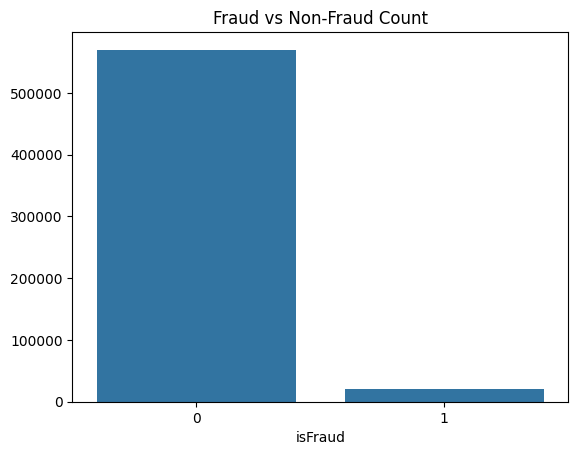

In [18]:
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs Non-Fraud Count")
plt.show()


In [19]:
trans["TransactionDT"].describe()


count      590,540.0000
mean     7,372,311.3101
std      4,617,223.6465
min         86,400.0000
25%      3,027,057.7500
50%      7,306,527.5000
75%     11,246,620.0000
max     15,811,131.0000
Name: TransactionDT, dtype: float64

C:\Users\BIT\AppData\Local\Temp\ipykernel_1848\4141196220.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.qcut(trans_sorted["TransactionDT"], 50))["isFraud"]


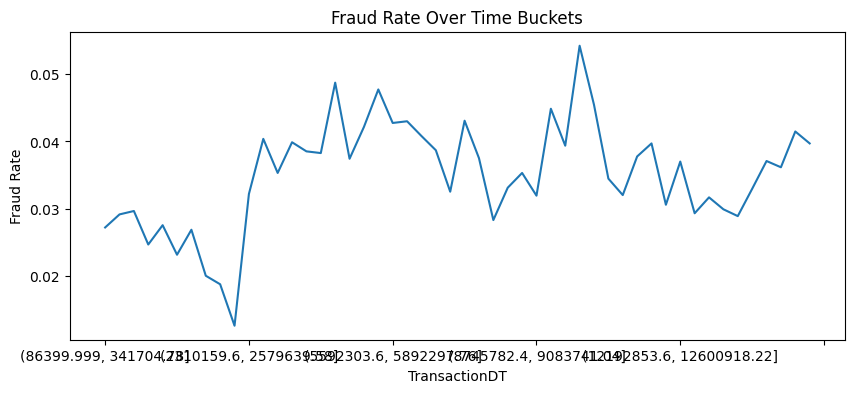

In [20]:
trans_sorted = trans.sort_values("TransactionDT")

fraud_over_time = (
    trans_sorted
    .groupby(pd.qcut(trans_sorted["TransactionDT"], 50))["isFraud"]
    .mean()
)

fraud_over_time.plot(figsize=(10,4), title="Fraud Rate Over Time Buckets")
plt.ylabel("Fraud Rate")
plt.show()


Fraud is not uniformly distributed

Justify time-based validation

Explicitly say random split = leakage

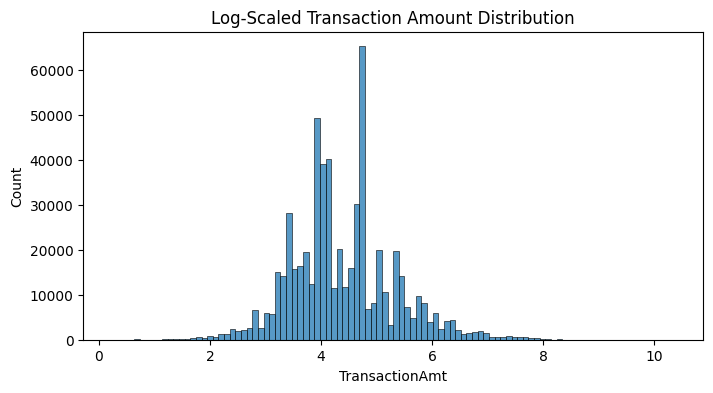

In [21]:
trans["TransactionAmt"].describe()
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(trans["TransactionAmt"]), bins=100)
plt.title("Log-Scaled Transaction Amount Distribution")
plt.show()


In [22]:
trans.groupby("isFraud")["TransactionAmt"].agg(["mean", "median"])


,mean,median
isFraud,,
0,134.5117,68.5000
1,149.2448,75.0000


C:\Users\BIT\AppData\Local\Temp\ipykernel_1848\1270256555.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amt = trans.groupby("amt_bin")["isFraud"].mean()


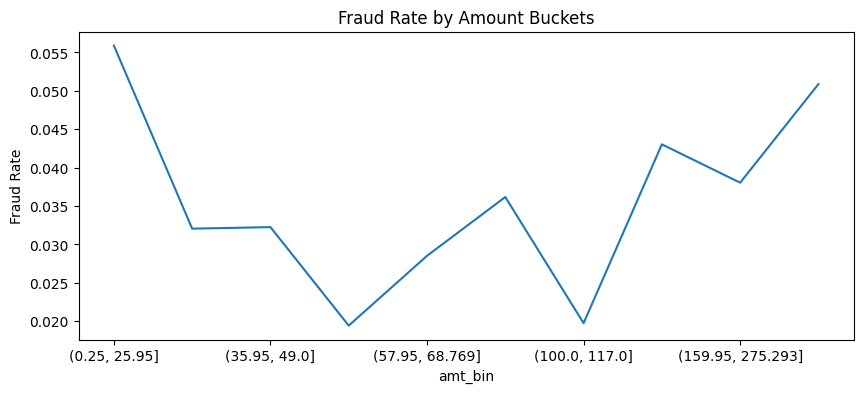

In [23]:
trans["amt_bin"] = pd.qcut(trans["TransactionAmt"], 10, duplicates="drop")

fraud_by_amt = trans.groupby("amt_bin")["isFraud"].mean()

fraud_by_amt.plot(figsize=(10,4), title="Fraud Rate by Amount Buckets")
plt.ylabel("Fraud Rate")
plt.show()


Fraud exists at both low and high amounts

Absolute amount < abnormality

In [24]:
trans["has_identity"] = trans["TransactionID"].isin(ident["TransactionID"])
trans["has_identity"].value_counts(normalize=True)
trans.groupby("has_identity")["isFraud"].mean()


has_identity
False   0.0209
True    0.0785
Name: isFraud, dtype: float64

Identity missingness is informative

LEFT JOIN later is mandatory

Missing ≠ bad data

In [25]:
feature_groups = {
    "Amount & Time": ["TransactionAmt", "TransactionDT"],
    "Card Features": [c for c in trans.columns if c.startswith("card")],
    "Address": ["addr1", "addr2"],
    "Email": ["P_emaildomain", "R_emaildomain"],
    "C Features": [c for c in trans.columns if c.startswith("C")],
    "D Features": [c for c in trans.columns if c.startswith("D")],
    "M Features": [c for c in trans.columns if c.startswith("M")],
    "V Features": [c for c in trans.columns if c.startswith("V")]
}

for k, v in feature_groups.items():
    print(f"{k}: {len(v)} features")


Amount & Time: 2 features
Card Features: 6 features
Address: 2 features
Email: 2 features
C Features: 14 features
D Features: 15 features
M Features: 9 features
V Features: 339 features


In [26]:
trans["card1"].nunique(), trans.shape[0]


(13553, 590540)

In [27]:
trans["card1"].value_counts().describe()


count   13,553.0000
mean        43.5726
std        329.0845
min          1.0000
25%          1.0000
50%          4.0000
75%         14.0000
max     14,932.0000
Name: count, dtype: float64

In [28]:
trans["P_emaildomain"].value_counts().head(10)


P_emaildomain
gmail.com        228355
yahoo.com        100934
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
att.net            4033
Name: count, dtype: int64

In [29]:
trans.groupby("isFraud")["has_identity"].mean()


isFraud
0   0.2332
1   0.5477
Name: has_identity, dtype: float64

In [30]:
card_txn_count = trans.groupby("card1")["TransactionID"].count()
trans["card_txn_count"] = trans["card1"].map(card_txn_count)

trans.groupby("isFraud")["card_txn_count"].mean()


isFraud
0   2,535.8545
1   2,334.6807
Name: card_txn_count, dtype: float64

Fraud is rare but temporally clustered

Identity data is sparse yet high-signal

Time defines behavior, not raw features

Relative behavior > absolute values

Entity-level aggregation is required